# Stellar Magnitudes
Part of Prof. Hanno Rein's ASTC02 course on Practical Astronomy. 
In this tutorial, we will read in a set of images and extract the relative apparent magnitude of stars with python. You will need to do this for your lab report. However, in addition to what is shown in this tutorial you should also:
- Do a dark field correction of your image before processing it.
- Stack a set of images as needed for dimmer stars.

This notebook requires you to `pip install` the packages `numpy`, `matplotlib`, and `imageio`. The system default Python package `glob` should already be available.

In [1]:
from imageio.v3 import imread
import numpy as np
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
%matplotlib inline

# Define the number of pixels sufficient to encapsulate a star.
STAR_RADIUS = 20

Here we define some useful functions for extracting and analyzing the stars.

In [2]:
def starLocation(image, threshold=None):
    '''
        Given an image of a star field, returns the x,y location of the brightest star closest to the centre of the frame.
        `threshold` defines the pixel brightness value for finding the star.
    '''
    
    # Sort pixels in the image by brightness.
    x,y = np.unravel_index(np.argsort(image.flatten()), image.shape)
    z = image[x,y]
    
    # Compute distance to centre of image in pixels.
    D = np.sqrt( (x - image.shape[0]//2)**2 + (y - image.shape[1]//2)**2)
    # Sort pixels by distance to centre.
    Dind = np.argsort(D)
    
    # Unless a specific threshold is specified, use 95% the max value in the image data.
    if threshold is None: threshold = 0.95 * np.max(image)
    
    # Start at the centre pixel and search until the brightness threshold is reached.
    for i in Dind: 
        if z[i] > threshold: break

    # Return the location of the brightest pixel closest to the centre.
    return x[i],y[i]

def starRegion(image, threshold=None):
    '''
        Given an image of a star field, returns a region around the star defined by the global constant STAR_RADIUS.
        This utilizes the `starLocation` function to find the location of the star.
        `threshold` defines the pixel brightness value for finding the star.
    '''
    # Get the location of the star of interest.
    x,y = starLocation(image, threshold = threshold)
    
    # Return a subset of the image around the location of the star defined by STAR_RADIUS.
    return image[x-STAR_RADIUS:x+STAR_RADIUS, y-STAR_RADIUS:y+STAR_RADIUS]
    
def fluxEstimate(star_region, exposure, Nframes):
    '''
        Given a image, exposure time, and the number of frames, returns an estimate of the flux of the star in frame.
        The relevant image of the star_region can be extracted from a star field image using `starRegion`.
    '''
    # Sum up all of the values of the pixels in the region of the star.
    pixel_sum = np.sum(star_region)
    
    # Return the flux of the star taking into consideration the exposure length and the number of frames.
    return pixel_sum/(exposure*Nframes)

Load all of the star field files in the working directory folder and sort them. It can be helpful to organize them by magnitude by changing the filenames beforehand.

In [5]:
files = glob('*.PNG') # Load all the image files in the current working directory folder. Make sure that the file extension matches your images.
files.sort() # Sort the file names.
print(f'Loaded {len(files)} out of 9 expected files.') # You should have 9 image files.

Loaded 1 out of 9 expected files.


Load all of the star fields and locate the relevant stars using the `starLocation` function. The figure below is to verify that the algorithm chooses the correct stars appropriately. If it doesn't draw a red box around the correct star, then adjust the `threshold` option of the `starLocation` function until it does.

Note that when we read the image files, we average the colour components. Colour is not important for this analysis and we get a slightly better signal to noise ratio by averaging them, rather than just picking one. If you pick just one, use the red channel as our camera is most sensitive in the red part of the spectrum.

IndexError: list index out of range

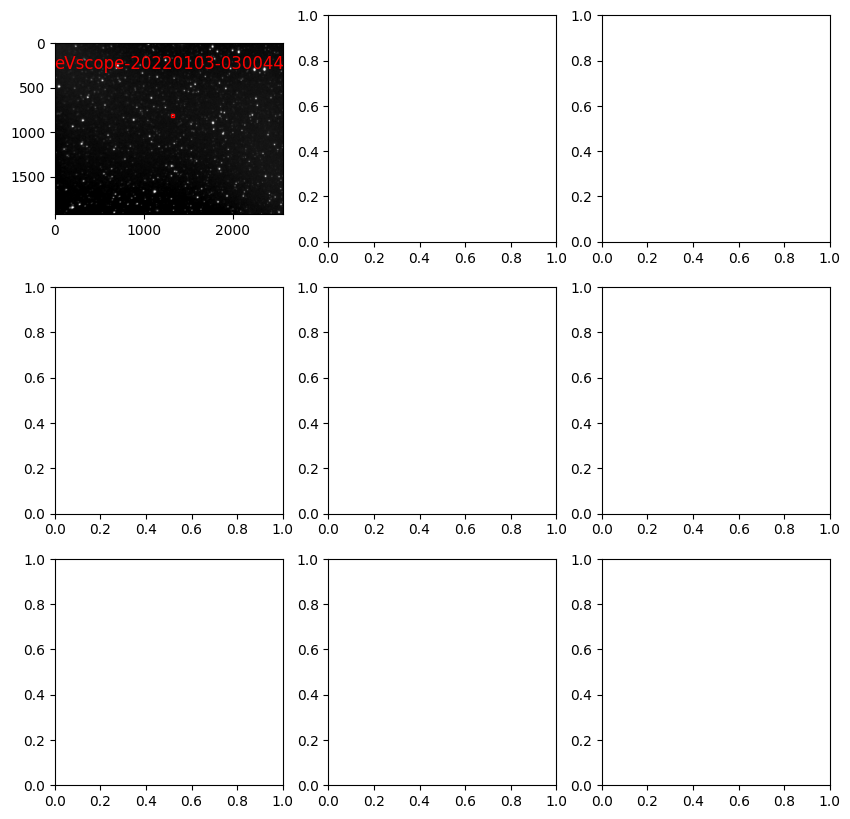

In [6]:
k = 0 # index for iterating through the files.

# Initialize the figure as a 3x3 grid.
fig, ax = plt.subplots(3,3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        # Read the images and average over the colour components.
        star = np.average(imread(files[k]),axis=2)
        
        # Locate the relevant star.
        xi,yi = starLocation(star)
        
        # Plot the star, a rectangle box around it, and add a title (using the filename).
        ax[i,j].imshow(star, cmap=cm.gray);
        ax[i,j].add_patch(Rectangle([yi-STAR_RADIUS,xi-STAR_RADIUS], 2*STAR_RADIUS, 2*STAR_RADIUS, edgecolor='r', facecolor='none'))
        star_name = files[k].split('.')[0]
        ax[i,j].set_title(star_name, y=0.8, color='r')
        
        k += 1 # Increment the index for iterating through the files.
# Adjust the subplots to be closer together.
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Apparent Magnitude
Without careful instrument calibration and instrument profiling we cannot measure the magnitude of stars directly. However, we can calculate the relative brightness between different stars.

In order to measure the apparent magnitude we need to measure the photon flux on our CCD. Since we can't do that directly, we will use pixel luminosity values as a proxy. Apparent magnitude is defined as $$m_i = -2.512 \log_{10}(F_i) + z_p,$$ where $F_i$ is the flux and $z_p$ is the zero point. More specifically flux is the amount of energy per second per area from a star, in other words, it is the number of photons from a star or galaxy that intersects a detector in an interval of time. Zero point ($z_p$) refers to a magnitude calibration that is specific to the observing conditions, filters and telescope. Strictly speaking, it represents the magnitude of an object with a flux of one count per second, but it also serves as a term that encompasses all calibrations (e.g. gain, filter system, etc.) and wraps them up into one neat term. It is estimated by comparing measured magnitudes to catalogued values of known stars.

We cannot measure flux or zero point directly, but we can estimate flux *so long as we have not over-saturated our image*. We can estimate the flux with $$F_i = \frac{(\mathrm{pixel\,sum\,for\,}i^\mathrm{th}\mathrm{\,star})}{(\mathrm{exposure) \cdot (number\,of\,frames})},$$ where `pixel sum` is the sum of the value of the pixels in the region around the star (including the star), `exposure` is the exposure time you manually set on the Unistellar telescope, and `number of frames` is the number of frames taken and stacked together. *Make sure that you do dark field correction for your images to remove background noise.*

Even with an estimate of the flux, we cannot measure apparent magnitude directly. So we will measure the relative difference in magnitude by simply subtracting our computed values against a reference value with $m_i - m_j$ for $i = \{0,1,...,n\}$ for $n$ files and $j \in i$.

Look up the exposure times and the number of frames used in your calibrated images and enter them as a list in the code cell below.

Also, $2.512$ is a magic number in astronomy defined historically to describe the relative brightness between two stars.

In [ ]:
def apparentMagnitude(F, zp):
    '''
        Given the flux of a star and a value for the zero point, returns the apparent magnitude.
    '''
    return -2.512 * np.log10(F) + zp

In [ ]:
# Define the lists of exposure times and the number of frames for each star field.
exposure = np.array([???]) # in miliseconds
frames = np.array([???]) # Number of frames

flux = np.zeros(len(files))
k = 0

fig, ax = plt.subplots(3,3, figsize=(10,10), sharex=True, sharey=True)
for i in range(3):
    for j in range(3):
        # Read in a star field image from file.
        star = np.average(imread(files[k]),axis=2)
        
        # Extract the region around the star of interest.
        star_reg = starRegion(star)
        
        # Calculate the apparent magnitude using our proxy equation.
        flux[k] = fluxEstimate(star_reg, exposure[k], frames[k])
 
        # Plot the region around the star and add a title (using the filename).
        star_name = files[k].split('.')[0]
        ax[i,j].imshow(star_reg, vmin=0, vmax=255, cmap=cm.gray)
        ax[i,j].set_title(star_name, y=0.8, color='r')
        k += 1# Increment the index for iterating through the files.
# Adjust the subplots to be closer together.
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

With an estimate for the flux, we can now calculate the relative apparent magnitude between a reference star and the stars in our data set. Choose one of your stars to be your reference star. Also, enter the actual apparent magnitudes of the stars in your data set as a list for comparison to your estimated values.

In [ ]:
# Define the literature values for the apparent magnitudes for the stars in your data set.
actual = np.array([???])

# Select the index of which star to use as a reference.
ref_star = ???

# To get magnitudes close to the actual values you will need to include an offset.
offset = actual[ref_star]

# Compute the relative apparent magnitudes of the stars in your data set.
relative_magnitude = ???

# Compare the estimated apparant magnitudes to the literature values.
print('Est. Act. RelDif')
reldiff_m = 100*np.abs((relative_magnitude-actual)/actual)
for k in range(9):
    print(f'{relative_magnitude[k]:.2f} {actual[k]:.2f} {reldiff_m[k]:5.1f}%')

## Absolute Magnitude
Absolute magnitude is a measure of the true luminosity of a star or its intrinsic brightness. Absolute brightness is similar to apparent brightness, but it's the brightness measure of any object at a distance of 10 parsecs (32.6 lightyears) away. It is denoted by $M$ and measured in magnitudes. It can be calculated from apparent magnitude $m$ using $$M = m + 5 - 5\log_{10}(d),$$ where $d$ is the distance to the star in parsecs.

We define a function `absoluteMagnitude` to do this. However, you will need to look up the distances to the stars in your data set (in parsecs or in lightyears and then convert them to parsecs).

In [ ]:
def absoluteMagnitude(m, d):
    '''
        Given the apparent magnitude and the distance to a star (in parsecs), returns the absolute magnitude.
    '''
    return m + 5 - 5*np.log10(d)

In [ ]:
# Define the literature values for the distances to the stars in your data set (in parsecs).
lightyears_to_parsecs = 0.3066
distances = np.array([???]) * lightyears_to_parsecs # pc

# Compute an estimate for the absolute magitude of your stars along with the literature values.
absolute_magnitude = absoluteMagnitude(relative_magnitude, distances)
actual_absmag = absoluteMagnitude(actual, distances)

# Compare the estimated absolute magnitudes to the literature values.
print('\t\t Est.  Act.   Rel Diff')
reldiff_M = 100*np.abs((absolute_magnitude-actual_absmag)/actual_absmag)
for k in range(9):
    print(f'{files[k].split(".")[0]:15s} {absolute_magnitude[k]:5.2f} {actual_absmag[k]:5.2f} {reldiff_M[k]:8.1f}%')